# Проект "Выбор локации для скважины"

## Введение

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:
 - В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
 - Строят модель для предсказания объёма запасов в новых скважинах;
 - Выбирают скважины с самыми высокими оценками значений;
 - Определяют регион с максимальной суммарной прибылью отобранных скважин.
 
Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Загрузка данных

In [1]:
!pip install -q phik


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', -1)
from sklearn.svm import SVC, SVR
matplotlib_axes_logger.setLevel('ERROR')
RANDOM_STATE = 42
TEST_SIZE = 0.25
sns.set()

In [3]:
df_geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
display(df_geo_data_0.head(5))
df_geo_data_0.info()

df_geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
display(df_geo_data_1.head(5))
df_geo_data_1.info()

df_geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
display(df_geo_data_2.head(5))
df_geo_data_2.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные в датасетах df_geo_data_0, df_geo_data_1 df_geo_data_2 соответствуют своему описанию, типы колонок соответствующие (возможно надо изменить тип object на тип string для параметра id). Размерность каждого датасета = 10000 х 5.
Пропусков в данных нет.

## Предобработка данных

In [4]:
def print_df_stats(df_tuples_list):
    for df_tuple in df_tuples_list:
        print(f'*** Dataframe {df_tuple[0]}')
        print(f'Number of duplicates by id: {df_tuple[1].duplicated(subset="id").sum()}')
        print(f'Number of duplicates without id: {df_tuple[1].duplicated(subset=df_tuple[1].columns.difference(["id"])).sum()}')
        display(df_tuple[1][df_tuple[1].columns.difference(["id"])].describe())
        print()

df_tuples_list = [("df_geo_data_0", df_geo_data_0), ("df_geo_data_1", df_geo_data_1), ("df_geo_data_2", df_geo_data_2)]
print_df_stats(df_tuples_list)

*** Dataframe df_geo_data_0
Number of duplicates by id: 10
Number of duplicates without id: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



*** Dataframe df_geo_data_1
Number of duplicates by id: 4
Number of duplicates without id: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



*** Dataframe df_geo_data_2
Number of duplicates by id: 4
Number of duplicates without id: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


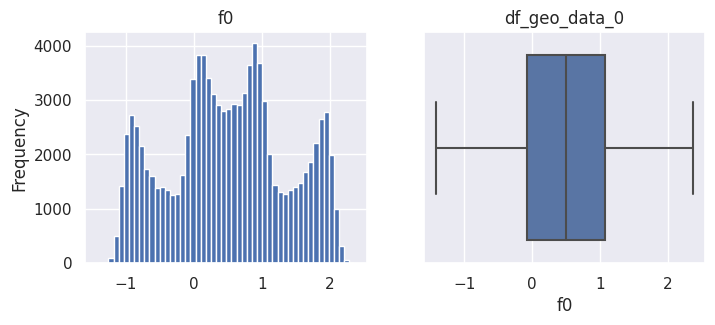

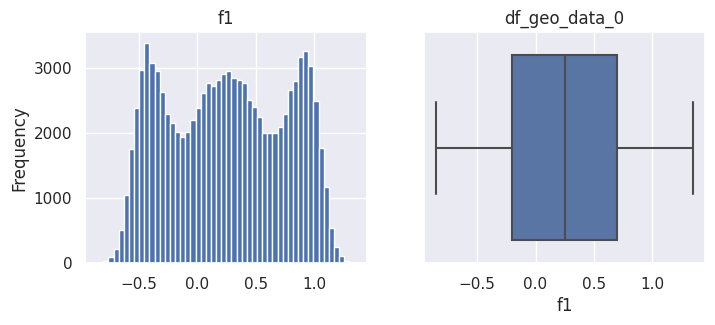

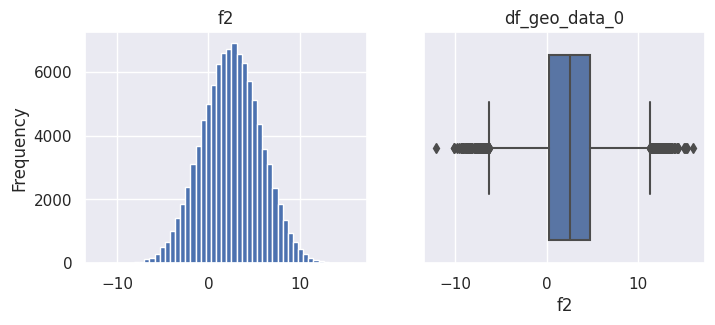

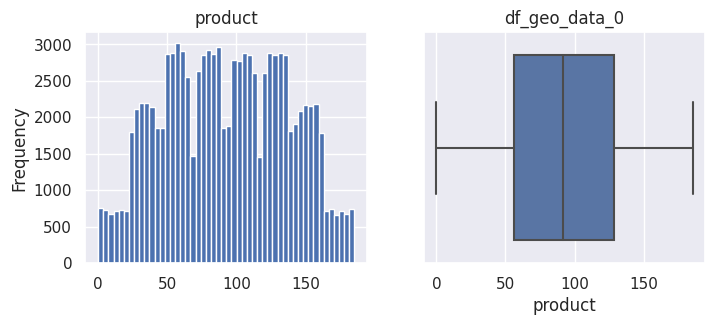

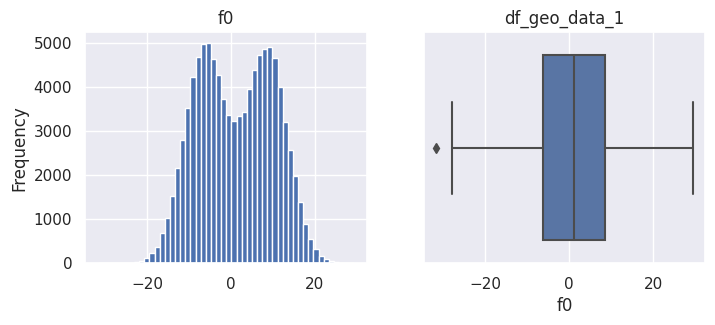

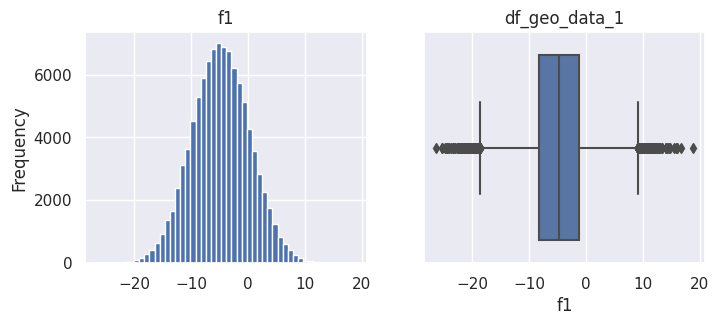

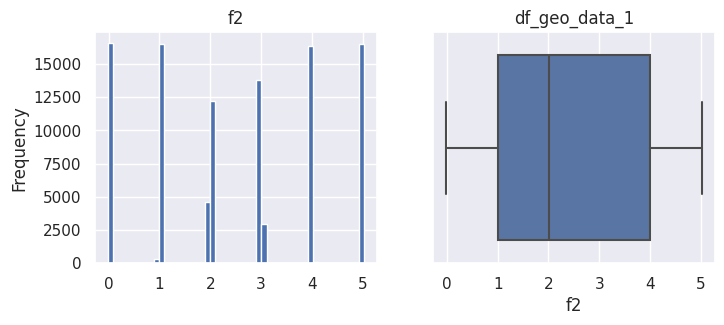

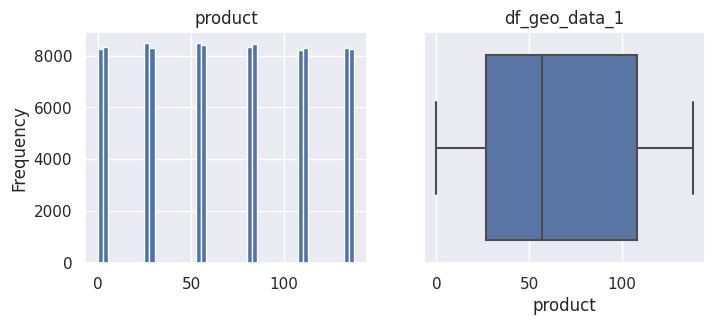

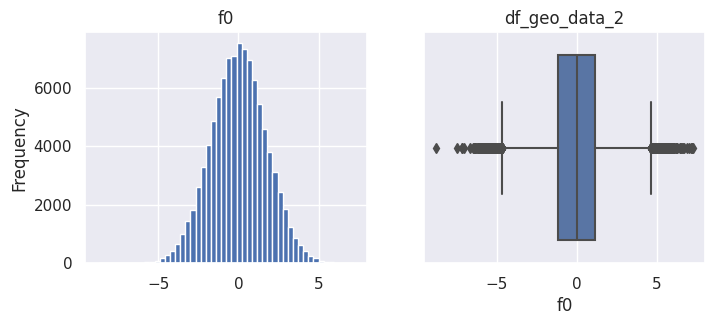

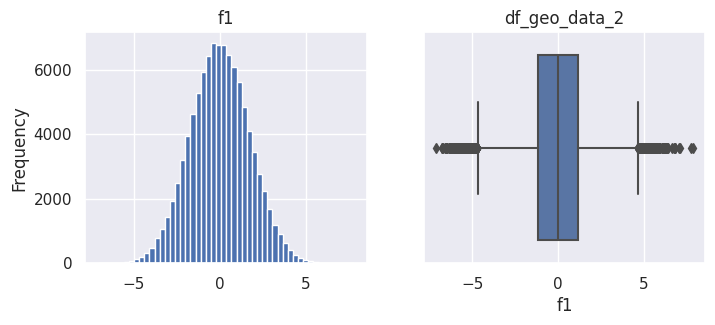

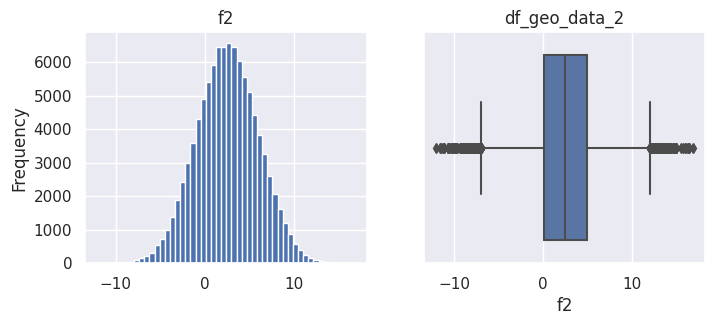

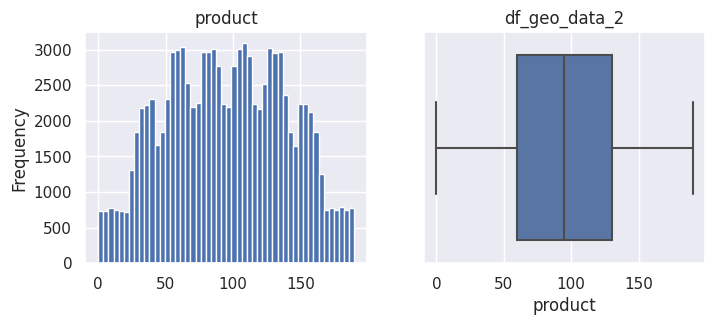

In [5]:
def plot_sub_plot_hist_boxplot(df_tuples_list):
    for df_tuple in df_tuples_list:
        for col in df_tuple[1].columns:
            if col == 'id':
                continue
            fig, axes = plt.subplots(nrows=1, ncols=2)
            df_tuple[1][col].plot(kind="hist", title=col, figsize=(8, 3), ax = axes[0], bins = 50)
            sns.boxplot(df_tuple[1][col], ax = axes[1])
            plt.title(df_tuple[0])
            plt.show()

plot_sub_plot_hist_boxplot(df_tuples_list)

На гистограммах более менее симметричная картина (mean ~ median), boxplots не показали больших выбросов для всех трех датафреймов. Оценка дубликатов по полю id показала что присутствует некоторое количество дубликатов по этому полю. Так как это уникальный индекс скважины то в этом поле дубликатов быть не должно и так как количество дубликатов (10, 4, 4) существенно меньше, чем общее число строк, то принято решение удалить эти дубликаты. По списку полей за исключением id дубликаты не обнаружены - если бы они были - пришлось бы либо удалять их либо реплейсить например медианой чтобы убрать коллинеарность.

In [6]:
df_geo_data_0 = df_geo_data_0.drop_duplicates(subset=['id'])
df_geo_data_0.info()
df_geo_data_1 = df_geo_data_1.drop_duplicates(subset=['id'])
df_geo_data_1.info()
df_geo_data_2 = df_geo_data_2.drop_duplicates(subset=['id'])
df_geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
--

Дубликаты по полю id удалены во всех трех датафреймах

## Исследовательский анализ данных

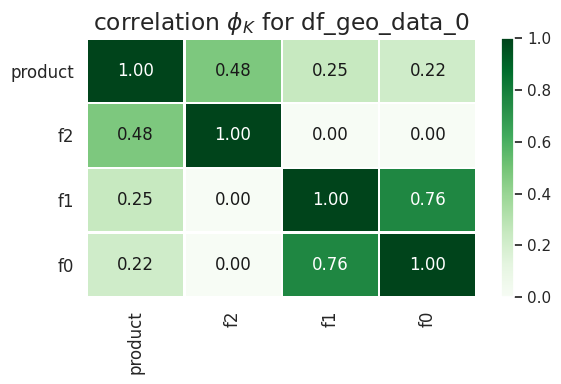

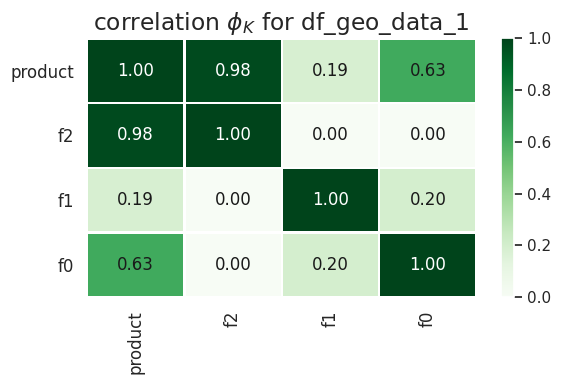

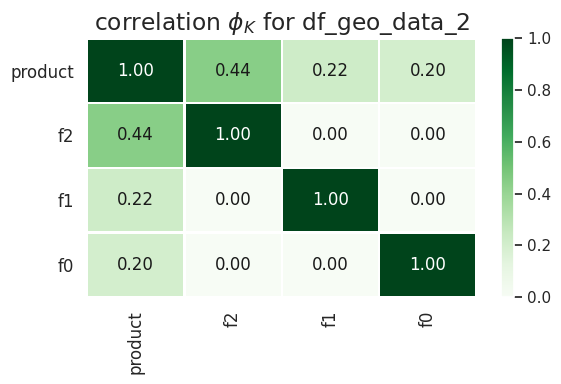

In [7]:
def show_phik_tuple_list(df_tuples_list):

    for df_tuple in df_tuples_list:
        phik_overview = phik_matrix(df_tuple[1][df_tuple[1].columns.difference(['id'])], interval_cols=list(df_tuple[1].columns.difference(['id'])))
        plot_correlation_matrix(
            phik_overview.values,
            x_labels=phik_overview.columns,
            y_labels=phik_overview.index,
            vmin=0, vmax=1, color_map='Greens',
            title=r'correlation $\phi_K$ for ' + df_tuple[0],
            fontsize_factor=1.2,
            figsize=(6, 4)
        )

show_phik_tuple_list(df_tuples_list)

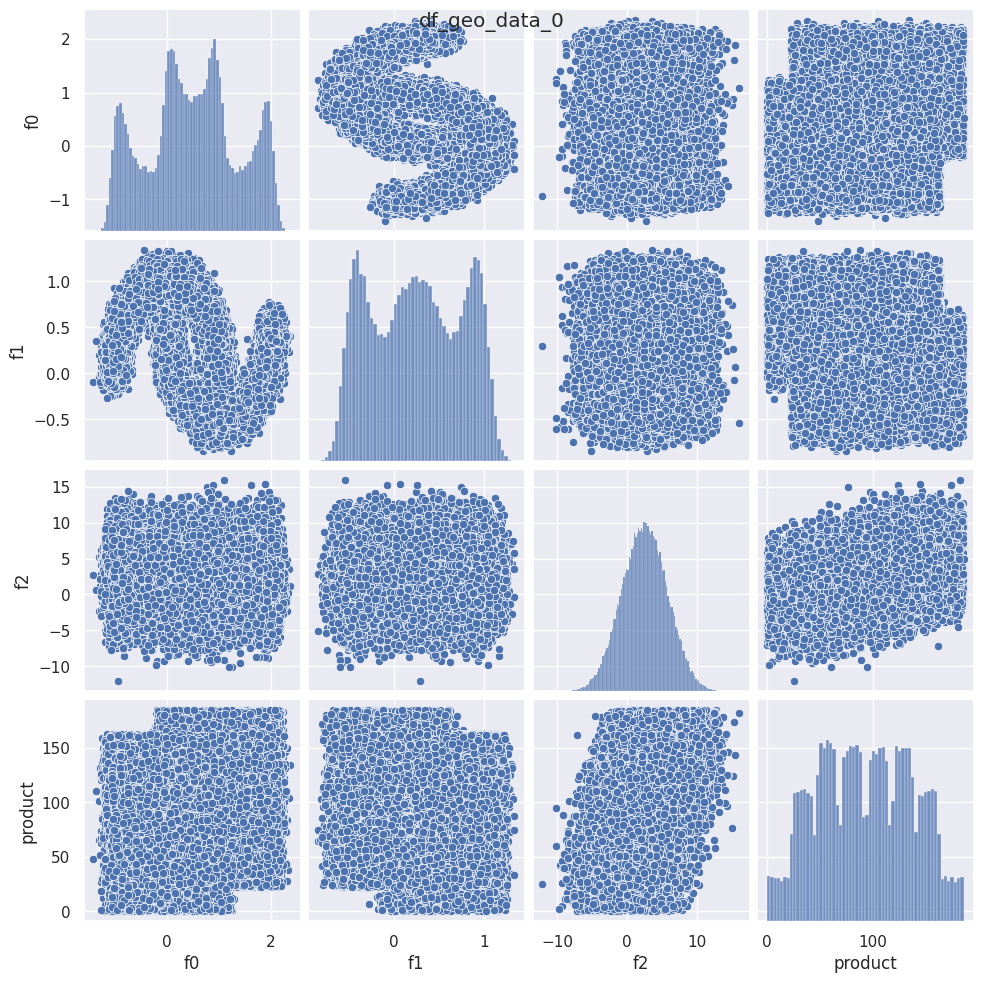

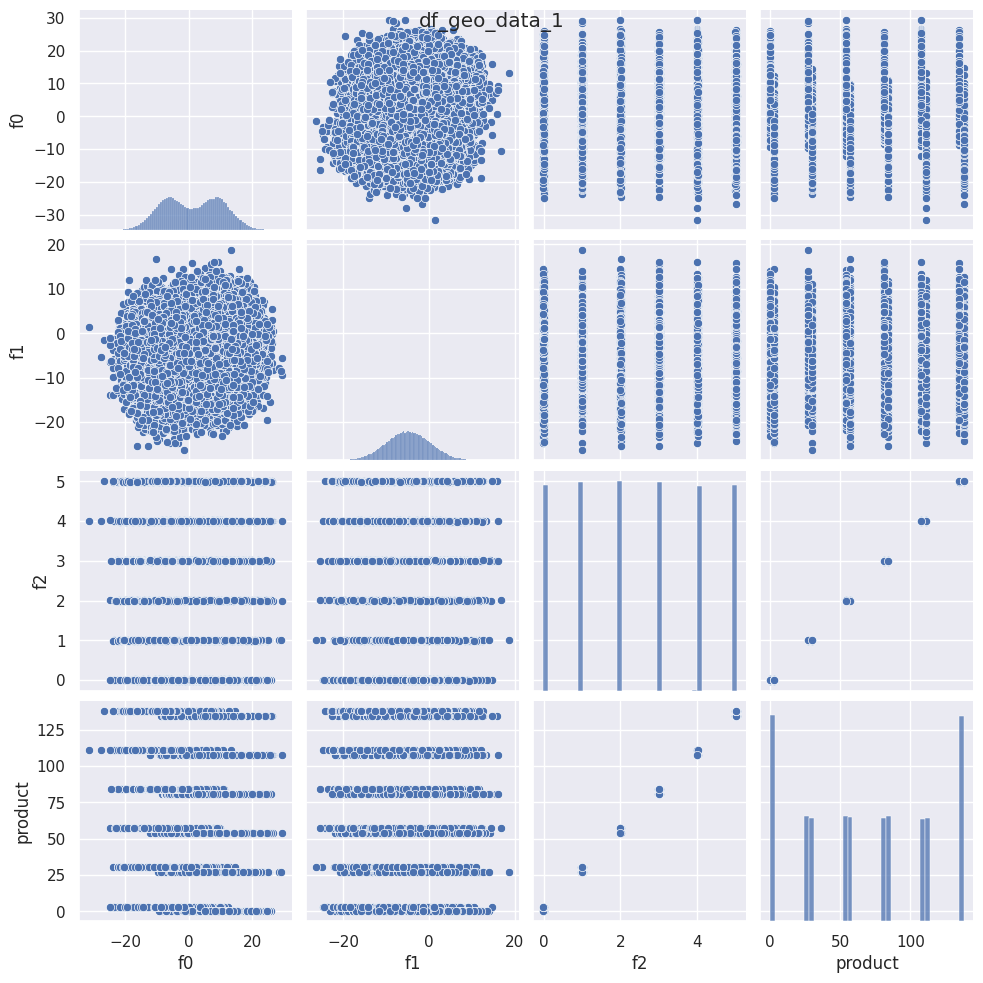

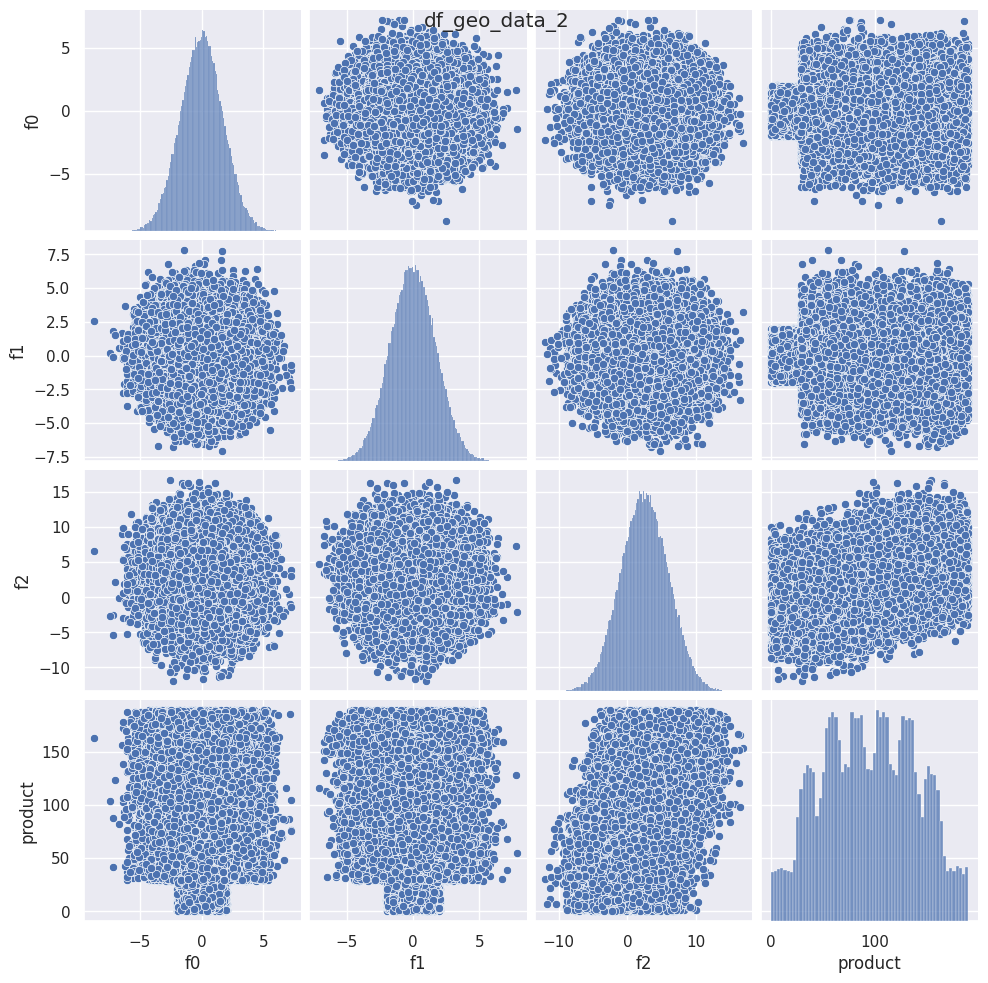

In [10]:
def show_pp_tuple_list(df_tuples_list):

    for df_tuple in df_tuples_list:
        g = sns.pairplot(df_tuple[1][df_tuple[1].columns.difference(['id'])], height=2.5)
        g.fig.suptitle(df_tuple[0])
        plt.show()

show_pp_tuple_list(df_tuples_list)

Анализ фик матрицы и парных scatter-графиков для трех датасетов показал, что:
- для региона 0 есть достаточно сильная корреляция между f0 и f1
- для региона 1 есть очень сильная корреляция между f2 и product и средняя корреляция между f0 и product
- scatter plots показали что для региона 1 есть строгая линейная зависимость между f2 и product, по остальным признакам сильной линейной зависимости не наблюдается

Я не вижу необходимости ни удалять входные параметры ни их модифицировать (например возведением в степень) так как природа этих данных мне неизвестна и я предлагаю их использовать as is. 

## Подготовка данных

## Обучение модели для каждого региона

### Разбиение данных на обучающую и валидационную выборки в соотношении 75:25

### Обучение модели и генерация предсказаний на валидационной выборке

### Сохранение предсказаний и правильных ответов на валидационной выборке

### Вывод среднего запаса предсказанного сырья и RMSE модели

### Анализ результатов

## Рассчет прибыли

### Все ключевые значения для расчётов сохранить в отдельных переменных

### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины

### Выводы

## Разработка функции для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Выбор скважины с максимальными значениями предсказаний

### Суммирование целевого значения объёма сырья, соответствующее этим предсказаниям

### Рассчет прибыли для полученного объёма сырья

## Рассчет рисков и прибыли для каждого региона

### Применение техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли

### Определение средней прибыли, 95%-й доверительного интервала и риска убытков

### Выводы по определению самого прибыльного региона

## Общие выводы